In [ ]:
USER = 'laphis'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MODEL_SAVE_PATH = '/content/gdrive/My Drive/Colab Notebooks/dacon_12/model_save/'

Mounted at /content/gdrive


In [ ]:
from google.colab import output

DATA_ZIP_PATH = '/content/gdrive/My Drive/Colab Notebooks/data/data_2/'

# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/gdrive/My Drive/Colab Notebooks/data/data_2_2.zip" "data_2_2.zip"
# data_2.zip을 현재 디렉터리에 압축해제
!unzip "data_2_2.zip"

Archive:  data_2_2.zip
  inflating: dirty_mnist_2nd.zip     
  inflating: dirty_mnist_2nd_answer.csv  
  inflating: mnist_data.zip          
  inflating: sample_submission.csv   
  inflating: test_dirty_mnist_2nd.zip  


In [ ]:
# 현재 디렉터리에 dirty_mnist라는 폴더 생성
!mkdir "./dirty_mnist_2nd"
#dirty_mnist.zip라는 zip파일을 dirty_mnist라는 폴더에 압축 풀기
!unzip "dirty_mnist_2nd.zip" -d "./dirty_mnist_2nd/"
# 현재 디렉터리에 test_dirty_mnist라는 폴더 생성
!mkdir "./test_dirty_mnist_2nd"
#test_dirty_mnist.zip라는 zip파일을 test_dirty_mnist라는 폴더에 압축 풀기
!unzip "test_dirty_mnist_2nd.zip" -d "./test_dirty_mnist_2nd/"
# 출력 결과 지우기
output.clear()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import imutils
import zipfile
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from google.colab import output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#dirty_mnist_answer = pd.read_csv(DIRTY_MNIST_ANSWER_PATH)

In [ ]:
dirty_mnist_answer = pd.read_csv('dirty_mnist_2nd_answer.csv')
# dirty_mnist라는 디렉터리 속에 들어있는 파일들의 이름을 
# namelist라는 변수에 저장
#namelist = os.listdir('./dirty_mnist/')

In [ ]:
dirty_mnist_answer

,index,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,0,1,1,0,1,0,1,0,0,0,0,1,1,0,0,1,1,0,1,1,0,1,0,0,1,1,1
1,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,1
2,2,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0
3,3,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1,1,0,1,1,0,1,0
4,4,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,0,1,1,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0
49996,49996,0,1,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,1
49997,49997,0,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0
49998,49998,0,1,1,1,0,0,1,1,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0


In [ ]:
#namelist = os.listdir(DIRTY_MNIST_PATH)

In [ ]:
# check on the images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [ ]:
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self,
                 dir_path,
                 meta_df,
                 transforms,
                 augmentations=None):
        self.dir_path = dir_path
        self.meta_df = meta_df

        self.transforms = transforms
        self.augmentations = augmentations

    def __len__(self):
        return len(self.meta_df)

    def __getitem__(self,index):

        #image = cv2.imread(self.dir_path +\
        #                   str(self.meta_df.iloc[index,0]).zfill(5) + '.png',
        #                   cv2.IMREAD_COLOR)
        
        image = Image.open(
            self.dir_path+str(self.meta_df.iloc[index,0]).zfill(5) + '.png',
        ).convert('RGB')

        image = self.transforms(image)

        # image = (image/255).astype('float')[..., np.newaxis]
        # might need to check on why this is necessary

        label = self.meta_df.iloc[index, 1:].values.astype('float')

        return image, torch.FloatTensor(label)

In [ ]:
class MultiLabelResnet(nn.Module):
    def __init__(self):
        super(MultiLabelResnet, self).__init__()
        self.resnet = models.resnet18()
        self.FC = nn.Linear(1000,26)

    def forward(self, x):

        x = F.relu(self.resnet(x))

        x = torch.sigmoid(self.FC(x))

        return x

In [ ]:
model = MultiLabelResnet()

In [ ]:
model.to(device)

MultiLabelResnet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
from sklearn.model_selection import KFold

best_models = []

train_transform = T.Compose([
                             T.RandomRotation(degrees=10),
                             T.RandomPerspective(distortion_scale=0.2),
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 2:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, train_transform)
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, eval_transform)

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(25):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        lr_scheduler.step()

        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            best_model = model
            MODEL = 'resnet18'
            path = MODEL_SAVE_PATH
            torch.save(best_model, f'{path}{USER}_{fold_index}_{MODEL}.pth')
    best_models.append(best_model)


[fold: 1]


Valid Epoch 24: 100%|██████████| 313/313 [00:13<00:00, 22.46batch/s, valid_acc=0.699, valid_loss=0.534]


[fold: 2]


Valid Epoch 24: 100%|██████████| 313/313 [00:13<00:00, 23.59batch/s, valid_acc=0.697, valid_loss=0.538]


[fold: 3]


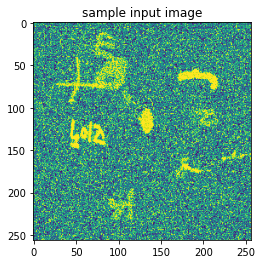

예측값 :  Index(['k', 'm', 'o', 't', 'w', 'x', 'z'], dtype='object')
예측값 :  Index(['a', 'b', 'f', 'j', 'k', 'm', 'n', 'r', 'u', 'x', 'y'], dtype='object')


In [ ]:
# check image and prediction
sample_images = images.cpu().detach().numpy()
sample_prob = probs
sample_labels = labels

idx = 1
plt.imshow(sample_images[idx][0])
plt.title("sample input image")
plt.show()

print('예측값 : ', dirty_mnist_answer.columns[1:][sample_prob[idx] > 0.5])
print('예측값 : ', dirty_mnist_answer.columns[1:][sample_labels[idx] > 0.5])

In [ ]:
# try ensemble and submit
sample_submission = pd.read_csv("sample_submission.csv")
test_dataset = DatasetMNIST("test_dirty_mnist_2nd/", sample_submission, eval_transform)

batch_size = 128

test_data_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 3,
    drop_last = False
)

In [ ]:
predictions_list = []

prediction_df = pd.read_csv("sample_submission.csv")

for model in best_models:

    prediction_array = np.zeros([prediction_df.shape[0],
                                 prediction_df.shape[1]-1])
    
    for idx, (images, _) in enumerate(test_data_loader):
        with torch.no_grad():
            model.eval()
            images = images.to(device)
            probs = model(images)
            probs = probs.cpu().detach().numpy()
            preds = (probs > 0.5)

            batch_index = batch_size * idx
            prediction_array[batch_index: batch_index + images.shape[0], :] = preds.astype(int)

    predictions_list.append(prediction_array[..., np.newaxis])

In [ ]:
predictions_array = np.concatenate(predictions_list, axis=2)
predictions_mean = predictions_array.mean(axis=2)

predictions_mean = (predictions_mean > 0.5) * 1 # * 1 이 필요하나
print(predictions_mean)

[[0 0 1 ... 1 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 1 0 1]]


In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.iloc[:, 1:] = predictions_mean
sample_submission.to_csv("submit.csv", index=False)
sample_submission

,index,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,50000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0
1,50001,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0
2,50002,0,0,1,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,1,1,0,0,0
3,50003,1,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1
4,50004,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,54995,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4996,54996,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0
4997,54997,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,1
4998,54998,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0


In [ ]:
# 0.69058